### А-05-19 Ушаков Никита НИР

#### Прогнозирование цен на фондовых рынках на основе метода случайного леса

В данном Jupyter Notebook представлены результаты анализа собранный данных фондового рынка, расчет соответствующих финансовых индикаторов,
процесс моделирования и обучения нейронной модели, предсказывающей будет ли акция закрываться вверх или вниз на основе ряда технических индикаторов, оценка полученных результатов.

In [1]:
import os
import sys
import requests as req
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from datetime import datetime as dt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report

pd.options.mode.chained_assignment = None

### Сбор данных

Используем конечную точку API, реализованного сервиса по сбору данных с фондового рынка

In [2]:
def fetch_data():
    urlAPI = "http://localhost:8080/get" 
    res = req.get(urlAPI)
    with open("res.csv", "wb") as file:
        file.write(res.content)

In [3]:
fetch_data()

Выведем первые 10 строк полученных данных:

In [4]:
stocks_df = pd.read_csv('res.csv')

stocks_df.head(n=10)

,ticker,open,close,highest,lowest,timestamp,volume
0,A,150.76,150.42,152.18,148.540,1639976400000,2027207.0
1,A,151.00,153.96,154.06,150.610,1640062800000,1496640.0
2,A,154.45,156.78,157.16,154.250,1640149200000,1907868.0
3,A,157.29,157.80,158.86,156.650,1640235600000,1411035.0
4,A,158.82,158.74,159.84,157.185,1640581200000,951771.0
5,A,159.68,159.18,159.79,158.120,1640667600000,764279.0
6,A,159.83,160.65,161.39,159.175,1640754000000,833052.0
7,A,161.11,160.88,162.62,160.600,1640840400000,771020.0
8,A,160.35,159.65,161.45,159.520,1640926800000,1315542.0
9,A,159.00,156.48,159.44,153.930,1641186000000,1606323.0


### Визуализация данных

Отфильтруем данные по тикеру компании Apple Inc.

In [5]:
filtered_df = stocks_df[stocks_df['ticker'] == 'AAPL'] 
filtered_df.head(n=10)

,ticker,open,close,highest,lowest,timestamp,volume
8400,AAPL,168.280,169.75,170.5800,167.46,1639976400000,107499114.0
8401,AAPL,171.555,172.99,173.2000,169.12,1640062800000,91167005.0
8402,AAPL,173.040,175.64,175.8600,172.15,1640149200000,92135303.0
8403,AAPL,175.850,176.28,176.8499,175.27,1640235600000,68356567.0
8404,AAPL,177.085,180.33,180.4200,177.07,1640581200000,74901582.0
8405,AAPL,180.160,179.29,181.3300,178.53,1640667600000,78894335.0
8406,AAPL,179.330,179.38,180.6300,178.14,1640754000000,62348931.0
8407,AAPL,179.470,178.20,180.5700,178.09,1640840400000,59773014.0
8408,AAPL,178.085,177.57,179.2300,177.26,1640926800000,64062261.0
8409,AAPL,177.830,182.01,182.8800,177.71,1641186000000,104677470.0


Сформируем и отобразим динамику цен закрытия акций для выбранной компании:

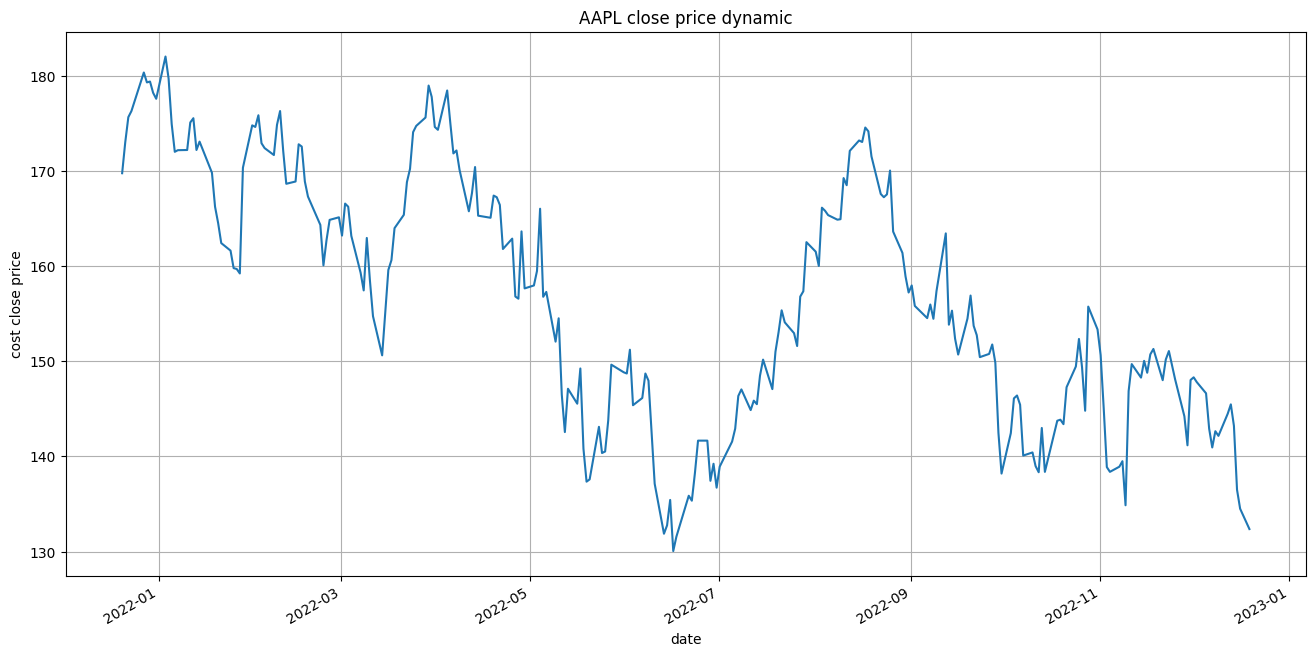

In [6]:
filtered_df['timestamp'] = pd.to_datetime(filtered_df['timestamp'], unit='ms')
filtered_df.set_index('timestamp', inplace=True)

filtered_df['close'].plot(figsize=(16,8), grid=True, title="AAPL close price dynamic")

plt.ylabel("cost close price") 
plt.xlabel("date")
plt.show()

Загруженные данные требуется преобразовать, чтобы рассчитать некоторые из торговых индикаторов. Первое, что необходимо сделать, это отсортировать данные по тикерам и временным меткам. 

In [7]:
stocks_df = stocks_df[['ticker','open','close','highest','lowest','timestamp','volume']]

stocks_df.sort_values(by = ['ticker','timestamp'], inplace = True)

После того, как данные были отсортированы, необходимо рассчитать изменение цены от одного периода к другому.

In [8]:
stocks_df['price_change'] = stocks_df['close'].diff()

Поскольку в представленных данных имеются различные тикеры, то ценовая разница между ними в текущий момент рассчитывается некорректно в момент перехода от одного тикера к другому. Необходимо, чтобы первая строка каждого нового тикера была Nan для price_change столбца данных. Проведем соответствующее разбиение, после чего выведем отфильтрованные значения с переходами между тикерами:

In [9]:
mask = stocks_df['ticker'] != stocks_df['ticker'].shift(1)

stocks_df['price_change'] = np.where(mask == True, np.nan, stocks_df['price_change'])

stocks_df[stocks_df.isna().any(axis = 1)]

,ticker,open,close,highest,lowest,timestamp,volume,price_change
0,A,150.7600,150.4200,152.1800,148.5400,1639976400000,2027207.0,NaN
252,AA,51.8900,53.1100,53.3550,51.3600,1639976400000,8394528.0,NaN
504,AAA,25.0300,25.0300,25.0300,25.0300,1639976400000,42.0,NaN
756,AAALF,33.0000,33.0000,33.0000,33.0000,1643778000000,1000.0,NaN
757,AAALY,35.0000,35.0000,35.0000,35.0000,1649131200000,1000.0,NaN
...,...,...,...,...,...,...,...,...
24495,ACCA,0.0001,0.0001,0.0001,0.0001,1642741200000,100.0,NaN
24518,ACCD,23.3700,23.9400,24.5500,22.9960,1639976400000,742874.0,NaN
24770,ACCFF,6.6491,6.5377,6.6491,6.5377,1642136400000,6425.0,NaN
24785,ACCMF,0.3580,0.3580,0.3580,0.3580,1641272400000,3000.0,NaN


### Расчет индикаторов

### RSI

RSI — индикатор импульса. Определяет, перекуплен ли рынок акций или перепродан. Акция считается перекупленной, когда спрос неоправданно толкает цену вверх. Это условие обычно интерпретируется как признак того, что акции переоценены и цена, вероятно, упадет. Говорят, что акции перепроданы, когда цена резко падает до уровня ниже ее истинной стоимости. Данный результат, обусловлен паническими продажами. 

RSI колеблется от 0 до 100. 
Обычно, когда RSI выше 70, индикатор указывает на перекупленность акций, когда RSI ниже 30, индикатор указывает на перепроданность акций.

Расчетная формула для индикатора RSI:
$$ RSI = 100 - \frac{100}{1+RS} $$

Для индикатора RSI необходимо определить дни роста и дни падения акции. Воспользуемся ранее вычисленным столбцом price_change, задавая условие, которое устанавлиет значение в 0, если цена росла в дни падения и наоборот. Далее необходимо убедиться, что имеются абсолютные значения для дней спада. Для этого вычисляем данный столбцец и ewm для столбцов down_days и up_days. ewm — среднее значение определенного количества предыдущих периодов. После чего можно вычислить показатель относительной силы relative_strength_index, который будет являться индикатором RSI. Расчет индикатора проведем для двухнедельного периода.

In [10]:
n = 14

In [11]:
up_df, down_df = stocks_df[['ticker','price_change']].copy(), stocks_df[['ticker','price_change']].copy()

up_df.loc['price_change'] = up_df.loc[(up_df['price_change'] < 0), 'price_change'] = 0

down_df.loc['price_change'] = down_df.loc[(down_df['price_change'] > 0), 'price_change'] = 0

down_df['price_change'] = down_df['price_change'].abs()

ewma_up = up_df.groupby('ticker')['price_change'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df.groupby('ticker')['price_change'].transform(lambda x: x.ewm(span = n).mean())

relative_strength = ewma_up / ewma_down

relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

stocks_df['down_days'] = down_df['price_change']
stocks_df['up_days'] = up_df['price_change']
stocks_df['rsi'] = relative_strength_index

stocks_df.head(30)

,ticker,open,close,highest,lowest,timestamp,volume,price_change,down_days,up_days,rsi
0,A,150.76,150.42,152.1800,148.5400,1639976400000,2027207.0,NaN,NaN,NaN,NaN
1,A,151.00,153.96,154.0600,150.6100,1640062800000,1496640.0,3.54,0.00,3.54,100.000000
2,A,154.45,156.78,157.1600,154.2500,1640149200000,1907868.0,2.82,0.00,2.82,100.000000
3,A,157.29,157.80,158.8600,156.6500,1640235600000,1411035.0,1.02,0.00,1.02,100.000000
4,A,158.82,158.74,159.8400,157.1850,1640581200000,951771.0,0.94,0.00,0.94,100.000000
5,A,159.68,159.18,159.7900,158.1200,1640667600000,764279.0,0.44,0.00,0.44,100.000000
6,A,159.83,160.65,161.3900,159.1750,1640754000000,833052.0,1.47,0.00,1.47,100.000000
7,A,161.11,160.88,162.6200,160.6000,1640840400000,771020.0,0.23,0.00,0.23,100.000000
8,A,160.35,159.65,161.4500,159.5200,1640926800000,1315542.0,-1.23,1.23,0.00,80.611568
9,A,159.00,156.48,159.4400,153.9300,1641186000000,1606323.0,-3.17,3.17,0.00,51.131293


### Стохастический осциллятор

Стохастический осциллятор следует за импульсом цены. Он измеряет уровень цены закрытия относительно диапазона минимум-максимум за определенный период времени.

Расчетная формула для индикатора:

$$ K = 100 \times \frac{(C-L_{14})}{(H_{14}-L_{14})} $$

Где:

$C$ - текущая цена закрытия, 

$L_{14}$ - самый низкий минимум цены за двухнедельных период, 

$H_{14}$ - самый высокий максимум цены за двухнедельный период.

Стратегия расчета подобна индикатору RSI. Для стохастического осциллятора мы используем функцию rolling, с помощью которой мы указываем двухнедельное окно из 14 периодов, после чего указываем измерение, которое будет применяться к каждому окну. После получения максимального и минимального значения, индикатор рассчитывается по формуле и результат применяется к фрейму данный.

In [12]:
low_14, high_14 = stocks_df[['ticker','lowest']].copy(), stocks_df[['ticker','highest']].copy()

low_14 = low_14.groupby('ticker')['lowest'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('ticker')['highest'].transform(lambda x: x.rolling(window = n).max())

k_percent = 100 * ((stocks_df['close'] - low_14) / (high_14 - low_14))

stocks_df['low_14'] = low_14
stocks_df['high_14'] = high_14
stocks_df['k_percent'] = k_percent

stocks_df.head(30)

,ticker,open,close,highest,lowest,timestamp,volume,price_change,down_days,up_days,rsi,low_14,high_14,k_percent
0,A,150.76,150.42,152.1800,148.5400,1639976400000,2027207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,151.00,153.96,154.0600,150.6100,1640062800000,1496640.0,3.54,0.00,3.54,100.000000,NaN,NaN,NaN
2,A,154.45,156.78,157.1600,154.2500,1640149200000,1907868.0,2.82,0.00,2.82,100.000000,NaN,NaN,NaN
3,A,157.29,157.80,158.8600,156.6500,1640235600000,1411035.0,1.02,0.00,1.02,100.000000,NaN,NaN,NaN
4,A,158.82,158.74,159.8400,157.1850,1640581200000,951771.0,0.94,0.00,0.94,100.000000,NaN,NaN,NaN
5,A,159.68,159.18,159.7900,158.1200,1640667600000,764279.0,0.44,0.00,0.44,100.000000,NaN,NaN,NaN
6,A,159.83,160.65,161.3900,159.1750,1640754000000,833052.0,1.47,0.00,1.47,100.000000,NaN,NaN,NaN
7,A,161.11,160.88,162.6200,160.6000,1640840400000,771020.0,0.23,0.00,0.23,100.000000,NaN,NaN,NaN
8,A,160.35,159.65,161.4500,159.5200,1640926800000,1315542.0,-1.23,1.23,0.00,80.611568,NaN,NaN,NaN
9,A,159.00,156.48,159.4400,153.9300,1641186000000,1606323.0,-3.17,3.17,0.00,51.131293,NaN,NaN,NaN


### Williams %R 

Williams %R находится в диапазоне от -100 до 0. Когда его значение выше -20, это указывает на сигнал на продажу, а когда его значение ниже -80, это указывает на сигнал на покупку.

Расчетная формула для индикатора:

$$ R = - 100 \times \frac{(H_{14}-C)}{(H_{14}-L_{14})} $$

Где:

$C$ - текущая цена закрытия, 

$L_{14}$ - самый низкий минимум цены за двухнедельных период, 

$H_{14}$ - самый высокий максимум цены за двухнедельный период.

In [13]:
low_14, high_14 = stocks_df[['ticker','lowest']].copy(), stocks_df[['ticker','highest']].copy()

low_14 = low_14.groupby('ticker')['lowest'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14.groupby('ticker')['highest'].transform(lambda x: x.rolling(window = n).max())

r_percent =  - 100 * ((high_14 - stocks_df['close']) / (high_14 - low_14))

stocks_df['r_percent'] = r_percent

stocks_df.head(30)

,ticker,open,close,highest,lowest,timestamp,volume,price_change,down_days,up_days,rsi,low_14,high_14,k_percent,r_percent
0,A,150.76,150.42,152.1800,148.5400,1639976400000,2027207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,151.00,153.96,154.0600,150.6100,1640062800000,1496640.0,3.54,0.00,3.54,100.000000,NaN,NaN,NaN,NaN
2,A,154.45,156.78,157.1600,154.2500,1640149200000,1907868.0,2.82,0.00,2.82,100.000000,NaN,NaN,NaN,NaN
3,A,157.29,157.80,158.8600,156.6500,1640235600000,1411035.0,1.02,0.00,1.02,100.000000,NaN,NaN,NaN,NaN
4,A,158.82,158.74,159.8400,157.1850,1640581200000,951771.0,0.94,0.00,0.94,100.000000,NaN,NaN,NaN,NaN
5,A,159.68,159.18,159.7900,158.1200,1640667600000,764279.0,0.44,0.00,0.44,100.000000,NaN,NaN,NaN,NaN
6,A,159.83,160.65,161.3900,159.1750,1640754000000,833052.0,1.47,0.00,1.47,100.000000,NaN,NaN,NaN,NaN
7,A,161.11,160.88,162.6200,160.6000,1640840400000,771020.0,0.23,0.00,0.23,100.000000,NaN,NaN,NaN,NaN
8,A,160.35,159.65,161.4500,159.5200,1640926800000,1315542.0,-1.23,1.23,0.00,80.611568,NaN,NaN,NaN,NaN
9,A,159.00,156.48,159.4400,153.9300,1641186000000,1606323.0,-3.17,3.17,0.00,51.131293,NaN,NaN,NaN,NaN


### Скорость изменения цены 

Данный индикатор измеряет последнее изменение цены по отношению к цене в n дней ранее.

Рассчетная формула для индикатора:

$$ ROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}} $$

Где:

$C_{t}$ - скорость изменения цены в момент времени $t$,

$C_{t-n}$ - цена закрытия в момент времени $t$.

Для расчета данного используем встроеную функцию pandas, а именно, pct_change, которая рассчитает процентное изменение между текущей и предыдущей ценой.

In [14]:
stocks_df['roc'] = stocks_df.groupby('ticker')['close'].transform(lambda x: x.pct_change(periods = n))

stocks_df.head(30)

,ticker,open,close,highest,lowest,timestamp,volume,price_change,down_days,up_days,rsi,low_14,high_14,k_percent,r_percent,roc
0,A,150.76,150.42,152.1800,148.5400,1639976400000,2027207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,151.00,153.96,154.0600,150.6100,1640062800000,1496640.0,3.54,0.00,3.54,100.000000,NaN,NaN,NaN,NaN,NaN
2,A,154.45,156.78,157.1600,154.2500,1640149200000,1907868.0,2.82,0.00,2.82,100.000000,NaN,NaN,NaN,NaN,NaN
3,A,157.29,157.80,158.8600,156.6500,1640235600000,1411035.0,1.02,0.00,1.02,100.000000,NaN,NaN,NaN,NaN,NaN
4,A,158.82,158.74,159.8400,157.1850,1640581200000,951771.0,0.94,0.00,0.94,100.000000,NaN,NaN,NaN,NaN,NaN
5,A,159.68,159.18,159.7900,158.1200,1640667600000,764279.0,0.44,0.00,0.44,100.000000,NaN,NaN,NaN,NaN,NaN
6,A,159.83,160.65,161.3900,159.1750,1640754000000,833052.0,1.47,0.00,1.47,100.000000,NaN,NaN,NaN,NaN,NaN
7,A,161.11,160.88,162.6200,160.6000,1640840400000,771020.0,0.23,0.00,0.23,100.000000,NaN,NaN,NaN,NaN,NaN
8,A,160.35,159.65,161.4500,159.5200,1640926800000,1315542.0,-1.23,1.23,0.00,80.611568,NaN,NaN,NaN,NaN,NaN
9,A,159.00,156.48,159.4400,153.9300,1641186000000,1606323.0,-3.17,3.17,0.00,51.131293,NaN,NaN,NaN,NaN,NaN


### Построение нейронной модели

Поскольку исходной задачей является задача классификации, необходимо сформировать результирующий столбец, который будет сигнализировать о том, положительно или отрицательно закрылись торги для конкретного тикера, то есть закрылась ли акция вверх или вниз. Сгуппируем имеющийся фрейм данных по тикерам, после чего снова воспользуемся функцией pct_change установив значение period равное n=1, то есть одному дню. Будем считать, нулевое изменение цены положительным результатом, в таком случае исходная задача сводится к задаче бинарной классификации, и для сформированного результирующего столбца можно применить знаковую функцию sign, получив тем самым необходимое представление. 

In [15]:
close_groups = stocks_df.groupby('ticker')['close']

close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

stocks_df['result'] = close_groups

stocks_df.loc[stocks_df['result'] == 0.0] = 1.0

stocks_df.head(30)

,ticker,open,close,highest,lowest,timestamp,volume,price_change,down_days,up_days,rsi,low_14,high_14,k_percent,r_percent,roc,result
0,A,150.76,150.42,152.1800,148.5400,1639976400000,2027207.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,A,151.00,153.96,154.0600,150.6100,1640062800000,1496640.0,3.54,0.00,3.54,100.000000,NaN,NaN,NaN,NaN,NaN,1.0
2,A,154.45,156.78,157.1600,154.2500,1640149200000,1907868.0,2.82,0.00,2.82,100.000000,NaN,NaN,NaN,NaN,NaN,1.0
3,A,157.29,157.80,158.8600,156.6500,1640235600000,1411035.0,1.02,0.00,1.02,100.000000,NaN,NaN,NaN,NaN,NaN,1.0
4,A,158.82,158.74,159.8400,157.1850,1640581200000,951771.0,0.94,0.00,0.94,100.000000,NaN,NaN,NaN,NaN,NaN,1.0
5,A,159.68,159.18,159.7900,158.1200,1640667600000,764279.0,0.44,0.00,0.44,100.000000,NaN,NaN,NaN,NaN,NaN,1.0
6,A,159.83,160.65,161.3900,159.1750,1640754000000,833052.0,1.47,0.00,1.47,100.000000,NaN,NaN,NaN,NaN,NaN,1.0
7,A,161.11,160.88,162.6200,160.6000,1640840400000,771020.0,0.23,0.00,0.23,100.000000,NaN,NaN,NaN,NaN,NaN,1.0
8,A,160.35,159.65,161.4500,159.5200,1640926800000,1315542.0,-1.23,1.23,0.00,80.611568,NaN,NaN,NaN,NaN,NaN,-1.0
9,A,159.00,156.48,159.4400,153.9300,1641186000000,1606323.0,-3.17,3.17,0.00,51.131293,NaN,NaN,NaN,NaN,NaN,-1.0


Сохраним полученный результат в отдельный csv:

In [16]:
stocks_df.to_csv('out.csv')

Определим входные данные для модели нейронной сети, а так же разделим выборку на обучающую и тестовую.
Входными даннными будую являться рассчитаные ранее предикторы, выходными - результирующий столбец. Зададим размер тестовой выборки равный 20%, и разделим фрейм данных. Далее создадим модель классификации RandomForestClassifier, обучим ее на разделенной обучающей выборке.

### Постобработка данных

Модель нейронной сети RandomForestClassifier не может принимать NaN значения, поэтому необходимо удалить соотвествующие данные.

In [17]:
stocks_df = stocks_df.dropna()

stocks_df.head(30)

,ticker,open,close,highest,lowest,timestamp,volume,price_change,down_days,up_days,rsi,low_14,high_14,k_percent,r_percent,roc,result
14,A,143.29,145.16,145.3100,140.8600,1641790800000,2548145.0,0.01,0.00,0.01,20.138506,140.860,162.62,19.761029,-80.238971,-0.034969,1.0
15,A,145.00,146.64,146.9400,143.8100,1641877200000,2194208.0,1.48,0.00,1.48,29.571516,140.860,162.62,26.562500,-73.437500,-0.047545,1.0
16,A,147.80,149.51,150.3900,147.5500,1641963600000,2250847.0,2.87,0.00,2.87,44.294048,140.860,162.62,39.751838,-60.248162,-0.046371,1.0
17,A,149.46,145.17,149.5400,144.8500,1642050000000,1741764.0,-4.34,4.34,0.00,32.455904,140.860,162.62,19.806985,-80.193015,-0.080038,-1.0
18,A,144.04,144.68,145.1500,142.3600,1642136400000,2225442.0,-0.49,0.49,0.00,31.363904,140.860,162.62,17.555147,-82.444853,-0.088573,-1.0
19,A,142.42,140.47,143.2400,140.3400,1642482000000,1907368.0,-4.21,4.21,0.00,23.519080,140.340,162.62,0.583483,-99.416517,-0.117540,-1.0
20,A,140.67,140.43,143.6000,140.2600,1642568400000,1472206.0,-0.04,0.04,0.00,23.454766,140.260,162.62,0.760286,-99.239714,-0.125864,-1.0
21,A,141.38,139.48,143.1400,139.0500,1642654800000,1861384.0,-0.95,0.95,0.00,21.819648,139.050,161.45,1.919643,-98.080357,-0.133018,-1.0
22,A,139.54,137.51,140.4900,137.4900,1642741200000,1878663.0,-1.97,1.97,0.00,18.700343,137.490,159.44,0.091116,-99.908884,-0.138678,-1.0
23,A,136.38,138.12,138.4900,131.2800,1643000400000,2155299.0,0.61,0.00,0.61,22.651061,131.280,155.63,28.090349,-71.909651,-0.117331,1.0


In [18]:
x_samples = stocks_df[['rsi','k_percent','r_percent','roc']]
y_samples = stocks_df['result']

x_train, x_test, y_train, y_test = train_test_split(x_samples, y_samples, random_state = 0)

rf_classifier = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)

Обучим созданную модель нейронной сети:

In [19]:
rf_classifier.fit(x_train, y_train)

RandomForestClassifier(oob_score=True, random_state=0)

Проведем прогноз на тестовой выборке:

In [20]:
y_prediction = rf_classifier.predict(x_test)

### Оценка модели

Оценим точность полученной модели случайного леса:

In [21]:
print('accuracy: ', accuracy_score(y_test, rf_classifier.predict(x_test), normalize = True) * 100.0, " %")

accuracy:  69.91784653032687  %


### Метрики

Рассчитаем метрики точности построенной модели, сформировав отчет о классификации.

In [22]:
targets = ['stock_down_day', 'stock_up_day']

report = classification_report(y_true = y_test, 
                               y_pred = y_prediction, 
                               target_names = targets, 
                               output_dict = True)

metrics_df = pd.DataFrame(report).transpose()
metrics_df

,precision,recall,f1-score,support
stock_down_day,0.684192,0.698332,0.691190,2758.000000
stock_up_day,0.713696,0.699966,0.706764,2963.000000
accuracy,0.699178,0.699178,0.699178,0.699178
macro avg,0.698944,0.699149,0.698977,5721.000000
weighted avg,0.699472,0.699178,0.699256,5721.000000


#### Пояснение:

**accuracy** — метрика достоверности, расчитываемая по следующей формуле: $\frac{tp+tn}{tp+fp+fn+tn}$,

**precision** — метрика точности, показывающая отношение верно угаданных объектов класса ко всем объектам, определенным как объекты класса,

**recal** — метрика, показывающая отношение верно угаданных объектов класса ко всем представителям этого класса. 